In [36]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import tensorflow as tf
import numpy as np
import cv2
import shutil
import seaborn as sns
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [4]:
folders = os.listdir('gear_images')
for folder in folders:
    os.mkdir(os.path.join("Dataset", "Train", folder))
    os.mkdir(os.path.join("Dataset", "Test", folder))
    os.mkdir(os.path.join("Dataset", "Validation", folder))

In [6]:
for folder in folders:
    files = os.listdir(os.path.join("gear_images", folder))
    random.shuffle(files)
    m = len(files)
    
    train_files = files[0 : int( 0.7 * m)]
    validation_files = files[int( 0.7 * m) : int( 0.85 * m)]
    test_files = files[int( 0.85 * m) :]
    
    for file in train_files:
        shutil.copy(os.path.join("gear_images", folder, file), os.path.join("Dataset", "Train", folder, file))
    for file in validation_files:
        shutil.copy(os.path.join("gear_images", folder, file), os.path.join("Dataset", "Validation", folder, file))
    for file in test_files:
        shutil.copy(os.path.join("gear_images", folder, file), os.path.join("Dataset", "Test", folder, file))

Predicted : hardshell_jackets
Probability : 0.964253247


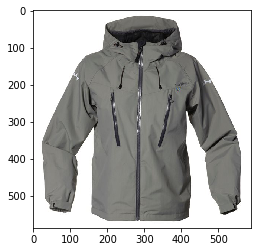

In [39]:
vision_base_url = "https://southcentralus.api.cognitive.microsoft.com/customvision/v1.1/Prediction/3620a4fa-71b9-41cf-b8b8-6b68437e56ee/url?iterationId=88c06f9c-14e7-44e2-a9a7-3897ea69df59" 
subscription_key = "a119055489f94732bcf36f91356437a2"
assert subscription_key
vision_analyze_url = vision_base_url# + "analyze"
image_url = "http://www.isbjornofsweden.com/images/2.5747/isbjorn-monsune-hardshell-jacket.jpeg"
# image_url = "https://images.pexels.com/photos/104827/cat-pet-animal-domestic-104827.jpeg?auto=compress&cs=tinysrgb&h=350"

from urllib.request import urlopen
f = open('test.jpg','wb')
f.write(urlopen(image_url).read())
f.close()

img = Image.open('test.jpg')
imshow(np.asarray(img))

Content_Type = "application/json"

import requests
headers  = {'Prediction-Key': subscription_key , 'Content-Type' : Content_Type}
# params   = {'visualFeatures': 'Categories,Description,Color'}
data     = {'url': image_url}
response = requests.post(vision_analyze_url, headers=headers, json=data)
response.raise_for_status()
analysis = response.json()
# print(analysis['Predictions'])

predictions = analysis['Predictions']
prob = 0
class_name = ""

for pred in predictions:
    if prob < pred['Probability']:
        prob = pred['Probability']
        class_name = pred["Tag"]

if prob < 0.90:
    print("Predicted : Others")
else:
    print("Predicted : " + class_name)
    print("Probability : " + str(prob))

# img = cv2.imread("Dataset/Validation/insulated_jackets/2032558_209_main.jpg")

# folders = ["hardshell_jackets", "insulated_jackets"]

# for folder in folders:
#     label = folder
#     files = os.listdir("Dataset", folder, file)
#     for file in files:
#         img = cv2.imread()

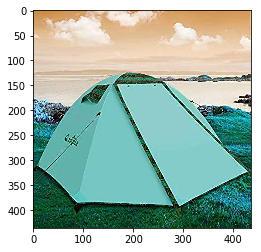

In [50]:
desired_size = 128
im_pth = "Dataset/Train/tents/51cQJ0cyE5L._AC_US436_QL65_.jpg"

im = cv2.imread(im_pth)
imshow(np.asarray(im))

In [62]:
def resize_and_pad(im, desired_shape = 128):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_im

In [63]:
def histequal(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    return img_output

In [100]:
def histogram(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    # plt.plot(cdf_normalized, color = 'g')
    plt.hist(img.flatten(),256,[0,256], color = 'b')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

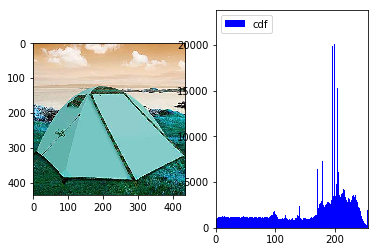

In [107]:
img = cv2.imread('Dataset/Train/tents/51cQJ0cyE5L._AC_US436_QL65_.jpg')
plt.subplot(121)
imshow(img)
plt.subplot(122)
histogram(img)

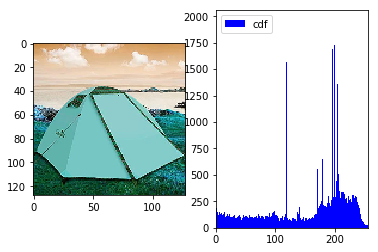

In [105]:
imgr = resize_and_pad(img)
plt.subplot(121)
imshow(imgr)
plt.subplot(122)
histogram(imgr)

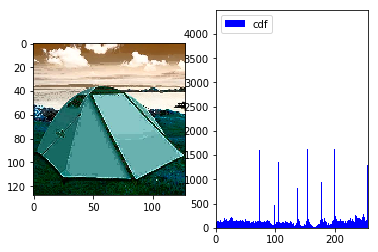

In [116]:
equ = histequal(imgr)
plt.subplot(121)
imshow(equ)
plt.subplot(122)
histogram(equ)

In [118]:
print(np.unique(equ))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

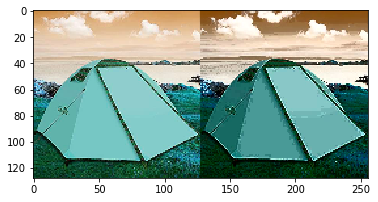

In [108]:
stc = np.hstack((imgr, equ))
imshow(stc)